# Predicting Performances of Configurable Systems:the Threat of Input Sensitivity

This notebook follows the order and produces all the figures depicted in the related submission.

#### First, we import some libraries

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures


# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

### Import data

In [3]:
data_dir = "../data/"
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

data = dict()
inputs_name = dict()
inputs_count = dict()
inputs_perf = dict()

inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["imagemagick"] = ["size", "time"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]


inputs_feat = dict()

inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["imagemagick"] = ["memory_r", "posterize_r", "gaussian-blur", "thread", "quality"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]


inputs_categ = dict()

inputs_categ["gcc"] = ["optim"]
inputs_categ["imagemagick"] = []
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']


for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = sorted(os.listdir(data_path))
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

In [5]:
s = 0
for key in data.keys():
    ns, i = key
    s+= data[key].shape[0]*len(inputs_perf[ns])
s

1976025

In [6]:
s = 0
time = 0
for key in data.keys():
    ns, i = key
    if ns == "x264":
        s+= data[key].shape[0]
        time+=np.sum(data[key]["etime"])
time/s

10.394419990242069

In [8]:
s = 0
time = 0
for key in data.keys():
    ns, i = key
    if ns == "imagemagick":
        s+= data[key].shape[0]
        time+=np.sum(data[key]["time"])
time/s

7.090334535464533

In [14]:
s = 0
time = 0
for key in data.keys():
    ns, i = key
    if ns == "gcc":
        s+= data[key].shape[0]
        time+=np.sum(data[key]["ctime"])
25*time/s

2.4919166666666666

# RQ1

A common assertion in the transfer learning community is that the more the source and the target environment are similar in terms of software performances, the more the transfer will outperform the simple machine learning (i.e. directly on the target environment, without transfer). 
However, inputs have different properties that may change the software behavior and thus alter software performances.
To reuse a performance model on multiple inputs (\ie trained on one input and tested on another input), the performance of software systems must be consistent across inputs.

## RQ1 - Do software performances stay consistent across inputs?

Are the performance distributions stable from one input to another? 
Are the rankings of performance the same for all inputs? 

To check this hypothesis, we compute, analyze and compare the Spearman's rank-order correlation of each couple of inputs for each system.

**Spearman correlations.**
The correlations are considered as a measure of similarity between the configurations' performances over two inputs. 
We use the Evans rule to interpret these correlations. In absolute value, we refer to correlations by the following labels; very low: 0-0.19, low: 0.2-0.39, moderate: 0.4-0.59, strong: 0.6-0.79, very strong: 0.8-1.00. 
A negative score tends to reverse the ranking of configurations. 
Very low or negative scores have practical implications: a good configuration for an input can very well exhibit bad performances for another input. 

### We define a function to plot and save the correlogram

In [3]:
def plot_correlationmatrix_dendogram(ns, dim):
    # ns : name_system
    # dim : dimension
    # output : a plot of an ordered correlogram of the different compile-time options
    
    # number of inputs
    inputs_nb = inputs_count[ns]

    corr = [[0 for x in range(inputs_nb)] for y in range(inputs_nb)]

    for i in range(inputs_nb):
        for j in range(inputs_nb):
            # A distribution of bitrates will have a correlaiton of 1 with itself
            if (i == j):
                corr[i][j] = 1
            else:
                # we compute the Spearman correlation between the input video i and the input video j
                corr[i][j] = sc.spearmanr(data[ns, i][dim],
                                          data[ns, j][dim]).correlation

    # we transform our matrix into a dataframe
    df = pd.DataFrame(corr)
    # we replace nan correlations (with a distribution whose values are all equal to 0)
    df = df.fillna(0)

    # group the videos, we choose the ward method 
    # single link method (minimum of distance) leads to numerous tiny clusters
    # centroid or average tend to split homogeneous clusters
    # and complete link aggregates unbalanced groups. 
    links = linkage(df, method="ward",)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    # we order the correlation following the aggregation clustering
    mask = np.zeros_like(corr, dtype=np.bool)

    for i in range(inputs_nb):
        for j in range(inputs_nb):    
            if i>j:
                mask[order[i]][order[j]] = True
    
    # compute the actual clustermap
    g = sns.clustermap(df, cmap="vlag", mask=mask, method="ward",
                   linewidths=0, figsize=(13, 13), 
                   cbar_kws={"ticks":[k/5 for k in np.arange(-10,10,1)]}, 
                   vmin =-1)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.tick_params(right=False, bottom=False)
    # abcissa and ordered labels
    g.ax_heatmap.set_xlabel("Inputs", fontsize = 18)
    g.ax_heatmap.set_ylabel("Inputs", fontsize = 18)
    # we save the figure in the result folder
    plt.savefig("../../results/systems/"+ns+"/"+"corr_"+dim+".png")
    # we show the graph
    plt.show()
    
    return corr

### Then, we define a function to summarize the distribution of correlations

To show some basic statistics, as the average value, the median, the quartiles, etc.

In [4]:
def describe(corr):
    
    corrDescription = [corr[i][j] for i in range(len(corr)) 
                              for j in range(len(corr)) if i >j]
    
    return np.round(pd.Series(corrDescription).describe(), 2)

# RESULTS RQ1 - Figure 3 : Poppler, extraction  time

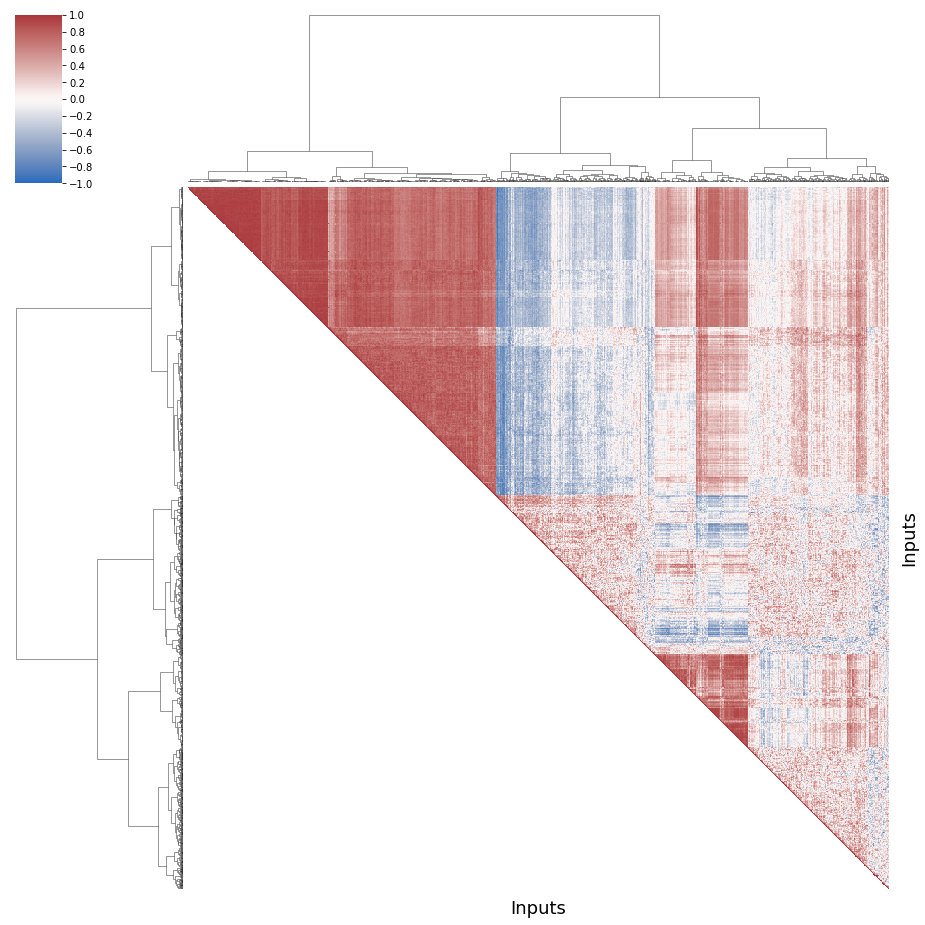

In [5]:
corr = plot_correlationmatrix_dendogram("poppler", "time")

In [6]:
describe(corr)

count    1094460.00
mean           0.19
std            0.41
min           -0.94
25%           -0.11
50%            0.15
75%            0.52
max            1.00
dtype: float64

The example of the paper.

The content of input pdfs fed to poppler may vary e.g. the pdf can be a 2-page report with a simple figure or a 300-page picture book. 
Depending on this content, extracting the images embedded in those files can be quick or slow. 
Moreover, a user can adapt different configurations for the report and not for the book (or inversely), leading to different rankings in terms of extraction time. 

In this correlogram, we depict the Spearman rank-order correlations, in terms of extraction time, between pairs of input pdfs fed to poppler. 
We also perform hierarchical clustering on poppler data to gather inputs having similar times distributions and visually group correlated pdfs together.
Each square$_{(i,j)}$ represents the Spearman correlation between the time needed to extract the images of pdfs $i$ and $j$. The color of this square respects the top-left scale: high positive correlations are red; low in white; negative in blue. Because we cannot describe each correlation individually, we added a table describing their distribution. The diagonals are excluded.
Results suggest a positive correlation (see dark red cells), though there are pairs of inputs with lower (see white cells) and even negative (see dark blue cells) correlations. 
More than a quarter of the correlations between input pdfs are positive and at least moderate (third quartile Q3 greater than \num{0.52}).

On the top-left part of the correlogram (see triangle 1 in the article), we even observe a first group of input pdfs that are highly correlated (positively, strong or very strong) with each others. 
In this first group, the input pdfs have similar time rankings; their performance react the same way to the same configurations. 

However, this group of pdfs is uncorrelated (very low, low) or negatively correlated (moderate, strong and very strong) with the second group of pdfs (see the triangle 2, in the middle). 
In this case, a performance model trained on a pdf chosen in the first group should not be reused directly on a pdf of the second group. 

# RQ2

But software performances are influenced by the configuration options e.g. the energy consumption. 
An option is called influential for a performance when its values have a strong effect on this performance. 
For example, developers might wonder whether the option they add to a configurable software has an influence on its performance.
However, is an option identified as influential for some inputs still influential for other inputs?
If not, it would become both tedious and time-consuming to find influential options on a per-input basis. 
Besides, it is unclear if activating an option is always worth it in terms of performance; an option could improve the overall performance but reduce it for few inputs. 
If so, users may wonder which options to enable to improve software performances based on their input data. 

In order to understand how a performance model can change based on a given input, we next study how input data interact with configuration options. 

## RQ2 - Do configuration option’s effects change with input data?


To assess the relative importances and effects of options, we use two well-known statistical methods. 


**Random Forest Importances.** The tree structure provides insights about the most essential options for prediction as a tree splits first options that provide the highest information gain. 
We use random forests (a vote between multiple decision trees):
we can derive, from the forests trained on the inputs, estimates of the options importance. 
The computation of option importance is realized through the observation of the eﬀect on random forest accuracy of randomly shuffling each predictor variable.
For a random forest, we consider that an option is influential if its option importance (i.e. median on all inputs) is greater than $\frac{1}{n_{opt}}$, where $n_{opt}$ is the number of options considered in the dataset. 
This threshold represents the theoretic importance of options for a software having equally important options (inspired by the Kaiser rule). 


**Linear Regression Coefficients.** The coefficients of an Ordinary Least Square (OLS) regression weight the effect of configuration options. 
These coefficients can be positive (resp. negative) if a bigger (resp. lower) option value results in a bigger performance. 
Ideally, the sign of the coefficients of a given option should remain the same for all inputs: it would suggest that the effect of an option onto performance is stableWe also provide details about coefficients related to the interactions of options (i.e. feature interactions).


### Compute importances

In [7]:
def compute_importances(ns, dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of importances
    listImportances = []
    
    features = inputs_feat[ns]
    to_keep = [f for f in features]
    to_keep.append(dim)
    categorial = inputs_categ[ns]

    # for each video of the list
    for id_input in range(inputs_count[ns]):
        
        # we replace missing numbers by 0
        df = data[ns, id_input][to_keep]
        
        df = df.replace(to_replace = "None", value = '0')
        
        # standardization
        for col in features:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            if col not in categorial:
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                # if the variable is categorial
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        # for each video, we train a model
        clf = RandomForestRegressor(n_estimators=20)
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = df[dim]
        # we train the model on all the data (not train-test since we don't use the model)
        clf.fit(X, y)
        
        # we add feature importances to the list
        listImportances.append(clf.feature_importances_)
    
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listImportances)):
        res['video_'+str(id_input)] = np.round(cs*listImportances[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
    # return it 
    return res

### Compute effects

In [8]:
def compute_coefs(ns, dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of coefficients
    listCoefs = []
    
    features = inputs_feat[ns]
    to_keep = [f for f in features]
    to_keep.append(dim)
    categorial = inputs_categ[ns]

    # for each video of the list
    for id_input in range(inputs_count[ns]):
        
        # we replace missing numbers by 0
        df = data[ns, id_input][to_keep]
        
        df = df.replace(to_replace = "NaN", value = '0')
        df = df.replace(to_replace = "None", value = '0')

        # standardization
        for col in to_keep:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            if col not in categorial:
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                # if the variable is categorial
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col], float)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        # for each video, we train a model
        indexes = np.array([k for k in range(len(df[dim])) 
                            if df[dim][k] != float("inf") and not np.isnan(df[dim][k])],int)
        lr = LinearRegression()
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = [float(k) for k in df[dim]]
        #print(y)
        # we train the model on all the data (not train-test since we don't use the model)
        lr.fit(X, y)
        # we add feature importances to the list
        listCoefs.append(lr.coef_)
    
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listCoefs)):
        res['video_'+str(id_input)] = np.round(cs*listCoefs[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
    # return it 
    return res

### Show the boxplot of effects and importances

In [11]:
def boxplot_imp(ns, dim, xlim = None, xname='Importances'):
    ### in: 
    #### ns the name of the system
    #### dim the name of the current performance property
    #### xlim limits if needed to focus on the important part of the chart
    #### xname the name of the abcissae and if we compute the importances or the effects
    ### out :
    #### a boxplot (saved in the system file)
    
    if xname == 'Importances':
        res = compute_importances(ns, dim)
    else:
        res = compute_coefs(ns, dim)
    
    # sort by names
    listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
               for col in res.columns]
    listImp.sort(key=lambda tup: tup[2], reverse=True)

    # see figures 2a and 2b
    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel(xname, size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if xname == 'Importances':
        plt.savefig("../../results/systems/"+ns+"/"+"boxplot_imp_"+dim+".png")
    else:
        plt.savefig("../../results/systems/"+ns+"/"+"boxplot_effect_"+dim+".png")
    plt.show()

# RESULTS RQ2 - Figures 4a and 4b : x264, bitrate

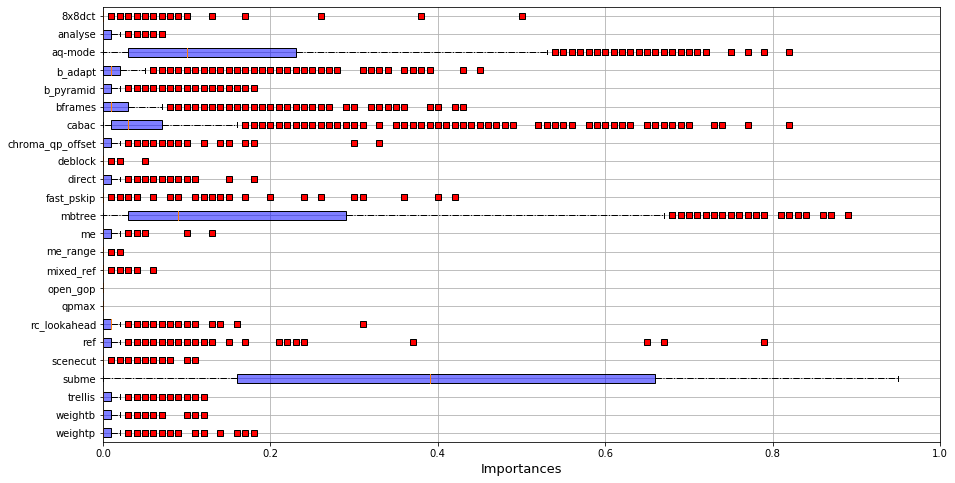

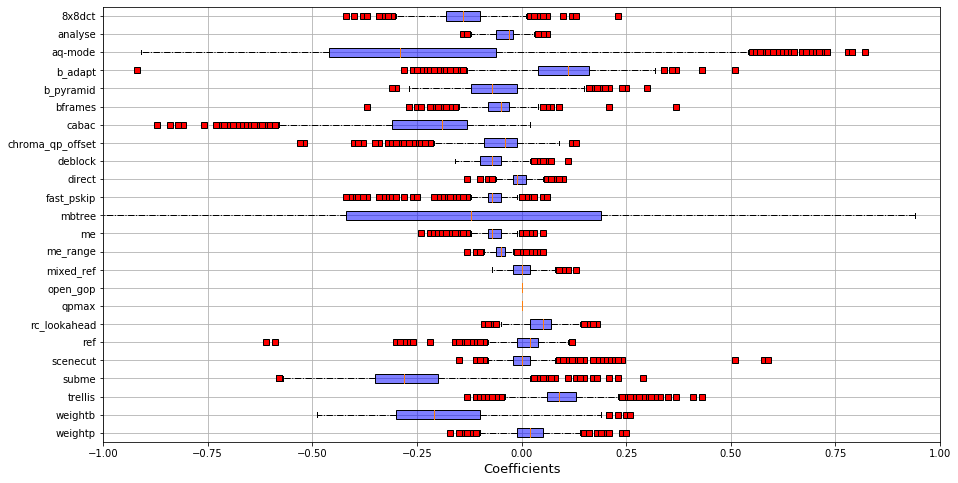

In [12]:
boxplot_imp("x264", "kbs", xlim =[0,1], xname='Importances')
boxplot_imp("x264", "kbs", xlim =[-1,1], xname='Coefficients')

# RQ3

RQ1 and RQ2 study how inputs affect (1) performance distributions and (2) the effects of different configuration options. 
However, the performance distributions could change in a negligible way, without affecting the software user's experience. 
Before concluding on the real impact of the input sensitivity, it is necessary to quantify how much this performance changes from one input to another. 
Next, we ask whether adapting the software to its input data is worth the cost of finding the right set of parameters \ie the concrete impact of input sensitivity. 


## RQ3 - Can we ignore input sensitivity?


To estimate how much we can lose, we first define two scenarios S1 and S2:

- *S1 - Baseline.* In this scenario, we just train a simple performance model on an input - i.e. the *target* input. We choose the best configuration according to the model, configure the related software with it and execute it with the target input.
- *S2 - Ignoring input sensitivity.* In this scenario, we train a model on a given input i.e. the *source* input, and then predict the best configuration for this source input. If we ignore the threat of input sensitivity, we can easily reuse this model for any other input, including the target input defined in S1. Finally, we execute the software with the configuration predicted by our model on the *target* input.

In this part, we systematically compare S1 and S2 in terms of performance for all inputs, all performance properties and all software systems. 
For S1, we repeat the scenario five times with different sources, uniformly chosen among other inputs and consider the average performance.
For both scenarios, and due to the imprecision of the learning procedure, the models can recommend sub-optimal configurations. 
To avoid adding this imprecision to the effect of input sensitivity, and in order to be fair, we consider that the models are oracles i.e. that they predict the best configuration each time.


**Performance ratio.**
To compare S1 and S2, we use a performance ratio i.e. the performance obtained in S1 over the performance obtained in S2. 
If the ratio is equal to 1, there is no difference between S1 and S2 and the input sensitivity does not exist.
A ratio of 1.4 would suggest that the performance of S1 is worth 1.4 times the performance of S2; therefore, it is possible to gain up to $(1.4-1)*100=40\%$ performance by choosing S1 instead of S2. 
We also report on the standard deviation of the performance ratio distribution. 
A standard deviation of 0 implies that for each input, we gain or lose the same proportion of performance when picking S1 over S2. 
As a comparison, we compute the performance ratio between extreme configurations i.e. the best over the worst.


# RQ3 code

In [18]:
data_dir = "../../data/"
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

data = dict()
inputs_name = dict()
inputs_count = dict()
inputs_perf = dict()

inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["imagemagick"] = ["time"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]


inputs_feat = dict()

inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["imagemagick"] = ["memory_r", "posterize_r", "gaussian-blur", "thread", "quality"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]


inputs_categ = dict()

inputs_categ["gcc"] = ["optim"]
inputs_categ["imagemagick"] = []
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']


for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = sorted(os.listdir(data_path))
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

## Compute the performance ratios.

In [19]:
def get_ratios(ns, perf):
    
    ratios = []
    
    nb_inputs = inputs_count[ns]
    
    for index_target in range(nb_inputs):

        list_ratios = []
        s1 = np.max(data[ns, index_target][perf])

        for i in range(10):
            index_source = np.random.randint(nb_inputs)
            s2 = data[ns, index_target][perf][np.argmax(data[ns, index_source][perf])]
            # we drop the ratios that are division per 0 or nan values
            if not np.isnan(s1) and not np.isnan(s2) and s2!=0:
                # we drop the ratios too high because it is just due to the fact that s2 is too low 
                # and it increases the standard deviation
                if int(s1/s2) <= 50:
                    list_ratios.append(s1/s2)

        ratios.append(np.nanmean(list_ratios))

    return (np.nanmean(ratios), 
            np.nanstd(ratios), 
            np.nanpercentile(ratios,5),
            np.nanpercentile(ratios,25),
            np.nanmedian(ratios),
            np.nanpercentile(ratios,75),
            np.nanpercentile(ratios,95))

# RESULTS RQ3 - Table 2 

In [20]:
header = ["Avg", "Std", "$5^{th}$", "Q1", "Q2", "Q3", "$95^{th}$"]
ratio = dict()
for ns in sorted(name_systems):
    print("Results for",ns)
    for perf in sorted(inputs_perf[ns]):
        print("Results", perf)
        numbers = [np.round(k,2) for k in get_ratios(ns, perf)]
        disp=""
        for i in range(len(numbers)):
            disp+=" "+header[i]+" "+str(numbers[i]) 
        print(disp)

Results for gcc
Results ctime
 Avg 1.14 Std 0.06 $5^{th}$ 1.05 Q1 1.09 Q2 1.12 Q3 1.19 $95^{th}$ 1.23
Results exec
 Avg 1.19 Std 0.22 $5^{th}$ 1.01 Q1 1.03 Q2 1.11 Q3 1.23 $95^{th}$ 1.6
Results size
 Avg 1.07 Std 0.07 $5^{th}$ 1.0 Q1 1.02 Q2 1.04 Q3 1.1 $95^{th}$ 1.15
Results for imagemagick
Results time
 Avg 1.05 Std 0.04 $5^{th}$ 1.01 Q1 1.02 Q2 1.03 Q3 1.06 $95^{th}$ 1.12
Results for lingeling
Results conflicts
 Avg 2.02 Std 2.81 $5^{th}$ 1.02 Q1 1.05 Q2 1.15 Q3 1.45 $95^{th}$ 5.88
Results cps
 Avg 1.82 Std 2.99 $5^{th}$ 1.02 Q1 1.05 Q2 1.15 Q3 1.44 $95^{th}$ 4.72
Results reductions
 Avg 1.37 Std 0.72 $5^{th}$ 1.0 Q1 1.04 Q2 1.11 Q3 1.27 $95^{th}$ 2.73
Results for nodejs
Results ops
 Avg 1.76 Std 1.95 $5^{th}$ 1.01 Q1 1.08 Q2 1.17 Q3 1.53 $95^{th}$ 3.99
Results for poppler
Results size
 Avg 1.6 Std 1.41 $5^{th}$ 1.0 Q1 1.0 Q2 1.08 Q3 1.53 $95^{th}$ 3.77
Results time
 Avg 2.68 Std 3.57 $5^{th}$ 1.03 Q1 1.14 Q2 1.37 Q3 2.27 $95^{th}$ 9.87
Results for sqlite
Results q1
 Avg 1.03 Std 0.

# Done! Thank you for testing this notebook!